In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings(action='ignore')

from utils import preprocessing as my_prep
from utils import regression as my_reg
from utils import evaluate as my_eval

# Data load

In [2]:
path_data = './data/seoul/prep2'

In [3]:
datas = {}
for filename in os.listdir(path_data):
    if filename.split('.')[-1] != 'csv':
        continue
    datas[filename[:6]] = pd.read_csv(os.path.join(path_data, filename), encoding='utf-8', engine='python')

In [4]:
list(datas.keys())

['2017_1',
 '2017_2',
 '2017_3',
 '2017_4',
 '2018_1',
 '2018_2',
 '2018_3',
 '2018_4',
 '2019_1',
 '2019_2',
 '2019_3',
 '2019_4']

In [5]:
tmp = datas['2019_4']
tmp = tmp[tmp['행정동_코드']=='송중동']
tmp[tmp['서비스_업종_코드_명']=='PC방']

,기준 년코드,기준_분기_코드,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,연령대_30_유동인구_수,연령대_40_유동인구_수,연령대_50_유동인구_수,...,남성연령대_50_유동인_수,남성연령대_60_유동인_수,여성연령대_10_유동인_수,여성연령대_20_유동인_수,여성연령대_30_유동인_수,여성연령대_40_유동인_수,여성연령대_50_유동인_수,여성연령대_60_유동인_수,서비스_업종_코드_명,당월_매출_금액
3032,2019,4,726848,336319,390530,106455,113538,91687,109945,112499,...,51039,76503,55082,59992,45889,51889,61456,116224,PC방,81280338
4921,2019,4,667690,297489,370201,86208,116608,93454,98626,104462,...,43829,66973,44839,64032,47767,51579,60637,101363,PC방,124582146
26956,2019,4,1017107,460155,556952,151358,125578,116187,138295,156043,...,71244,123183,72859,64259,55550,73018,84806,206461,PC방,78471993


# Split train, validate, test

In [6]:
trainfiles = ['2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3', '2018_4']
validatefiles = []
testfiles = ['2019_1', '2019_2', '2019_3', '2019_4']
#trainfiles = ['2017_1', '2018_1']
#validatefiles = []
#testfiles = ['2019_1']

train, validate, test = my_prep.split_train_val_test_by_file(datas, trainfiles, validatefiles, testfiles, category='PC방')
print(train.shape, validate.shape, test.shape)

[train] 2017_1 : (386, 27), accumulate : (386, 27)
[train] 2017_2 : (404, 27), accumulate : (790, 27)
[train] 2017_3 : (414, 27), accumulate : (1204, 27)
[train] 2017_4 : (425, 27), accumulate : (1629, 27)
[train] 2018_1 : (439, 27), accumulate : (2068, 27)
[train] 2018_2 : (448, 27), accumulate : (2516, 27)
[train] 2018_3 : (444, 27), accumulate : (2960, 27)
[train] 2018_4 : (447, 27), accumulate : (3407, 27)
[test] 2019_1 : (413, 27), accumulate : (413, 27)
[test] 2019_2 : (381, 27), accumulate : (794, 27)
[test] 2019_3 : (405, 27), accumulate : (1199, 27)
[test] 2019_4 : (430, 27), accumulate : (1629, 27)
(3407, 27) (0, 0) (1629, 27)


### split x, y

In [7]:
x_header = [x for x in train.columns if '연령대' in x and x.find('연령대')==0]
y_header = ['당월_매출_금액']
print(x_header, y_header)

['연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수'] ['당월_매출_금액']


In [8]:
x_train, y_train = my_prep.split_xy(train, x_header, y_header)
# x_validate, y_validate = my_prep.split_xy(validate, x_header, y_header)
x_test, y_test = my_prep.split_xy(test, x_header, y_header)

print('train', x_train.shape, y_train.shape)
# print('validate', x_validate, y_validate)
print('test', x_test.shape, y_test.shape)

train (3407, 6) (3407, 1)
test (1629, 6) (1629, 1)


### for random split

In [9]:
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))
print('train', x_train.shape, y_train.shape)

train (5036, 6) (5036, 1)


In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (3525, 6) (3525, 1)
test (1511, 6) (1511, 1)


# Normalize, Augmentation

### Normalize

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test)

scaler_y = StandardScaler().fit(y_train)
y_train_scale = scaler_y.transform(y_train)
y_test_scale = scaler_y.transform(y_test)


print('train', x_train_scale.shape, y_train_scale.shape)
print('test', x_test_scale.shape, y_test_scale.shape)

train (3525, 6) (3525, 1)
test (1511, 6) (1511, 1)


In [12]:
y_train_scale = y_train_scale.astype('float32')

In [138]:
pd.DataFrame(y_test).describe()

,0
count,1.511000e+03
mean,2.404421e+08
std,3.062908e+08
min,6.657300e+04
25%,6.622837e+07
50%,1.421743e+08
75%,2.926661e+08
max,3.804404e+09


In [13]:
tmp = pd.DataFrame(y_train_scale)
tmp.describe()

,0
count,3.525000e+03
mean,4.142734e-09
std,1.000141e+00
min,-7.256324e-01
25%,-5.532487e-01
50%,-3.390451e-01
75%,1.524475e-01
max,9.980984e+00


### Agumentation

In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
x_train_over,y_train_over = smote.fit_sample(x_train_scale, y_train_scale)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

ValueError: Unknown label type: 'continuous'

### Correlation coefficient

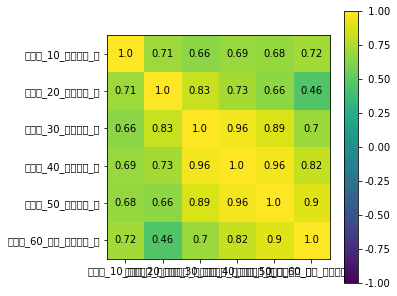

In [15]:
my_eval.visualize_CorrelCoeff_heatmap(x_train_scale, x_header, figsize=(5, 5))

# Training

In [52]:
hidden_layers = [512, 256, 4]

In [53]:
model_LR = my_reg.get_model_LinearRegression(x_train_scale, y_train_scale)
model_Elastic = my_reg.get_model_ElasticNet(x_train_scale, y_train_scale)
model_SVR = my_reg.get_model_SVR(x_train_scale, y_train_scale)
model_MLPRegression = my_reg.get_model_MLPRegression(
    x_train_scale, y_train_scale, 
    hidden_layers=hidden_layers,
    max_iter=5000,
    alpha=0.0001,
    random_state=42
)

In [34]:
model_LR.coef_

array([[ 0.26032935,  0.03793485,  0.55855321, -0.97658412,  0.51470345,
        -0.14316204]])

# Evaluate

### Linear Regression

------- evaluate Linear Regression -------
RMSE : 0.837576
R2 : 0.063183
----------------------------


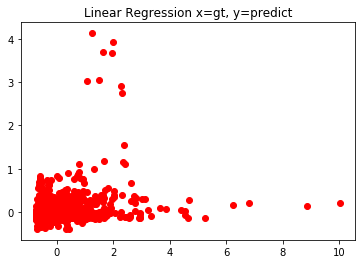

In [57]:
my_eval.eval_regression(y_test_scale, model_LR.predict(x_test_scale), model_name='Linear Regression')

### ElasticNet

------- evaluate ElasticNet -------
RMSE : 0.866593
R2 : -0.002851
----------------------------


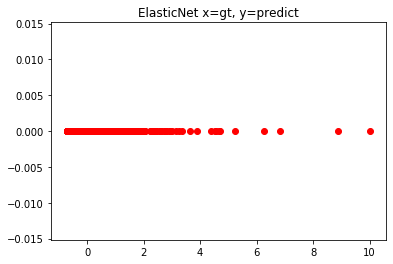

In [94]:
my_eval.eval_regression(y_test_scale, model_Elastic.predict(x_test_scale), model_name='ElasticNet')

### SVR

------- evaluate SVM Regression -------
RMSE : 389312717.177208
R2 : -0.616653
----------------------------


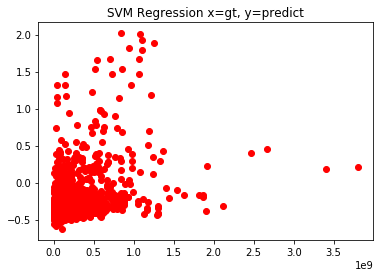

In [55]:
my_eval.eval_regression(y_test, model_SVR.predict(x_test_scale), model_name='SVM Regression')

# MLP Regressoin

------- evaluate MLP Regression -------
RMSE : 0.699499
R2 : 0.346597
----------------------------


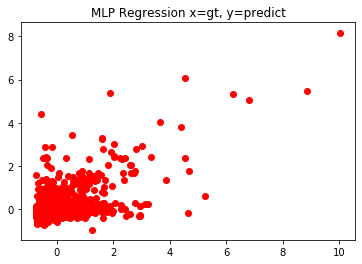

In [54]:
my_eval.eval_regression(y_test_scale, model_MLPRegression.predict(x_test_scale), model_name='MLP Regression')

# 오차 계산

In [226]:
def evaluate_error(y_gt, y_pred, title=''):
    li_error = []
    for i in zip(y_gt, y_pred):
        error = (abs(i[0]-i[1])/i[0])
        li_error.append(error)

    print(sum(li_error), y_pred.shape[0])
    print('평균 오차 %.lf%%' %(np.mean(li_error)))
    print('최대 오차 %.lf%%' %(np.max(li_error)))
    print('최소 오차 %.lf%%' %(np.min(li_error)))

    #li_error.sort(reverse=True)
    #print('Top 10 오차 %s' %(li_error[:10]))
    plt.plot(li_error)
    plt.title(title)

12021.20094452203 1511
평균 오차 8%
최대 오차 2462%
최소 오차 0%


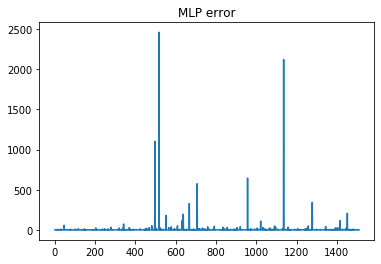

In [227]:
y_pred_scale_MLP = model_MLPRegression.predict(x_test_scale)
y_pred_MLP = scaler_y.inverse_transform(y_pred_scale)

evaluate_error(y_test[:, 0], y_pred_MLP, title='MLP error')

[13208.68056589] 1511
평균 오차 9%
최대 오차 2961%
최소 오차 0%


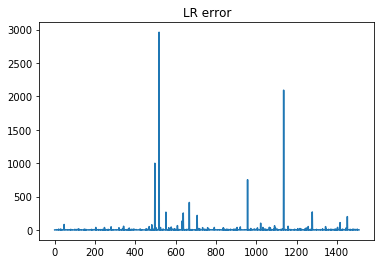

In [228]:
y_pred_scale_LR = model_LR.predict(x_test_scale)
y_pred_LR = scaler_y.inverse_transform(y_pred_scale_LR)

evaluate_error(y_test[:, 0], y_pred_LR, title="LR error")

15123.83836161175 1511
평균 오차 10%
최대 오차 3856%
최소 오차 0%


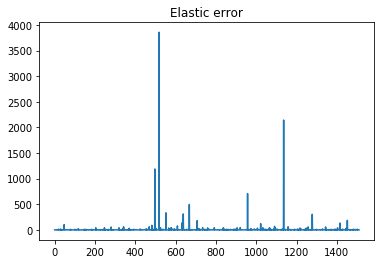

In [229]:
y_pred_scale_Elastic = model_Elastic.predict(x_test_scale)
y_pred_Elastic = scaler_y.inverse_transform(y_pred_scale_Elastic)

evaluate_error(y_test[:, 0], y_pred_Elastic, title='Elastic error')

# Conclusion

##### 정답 값이 너무 비슷? 몇명만 너무 큼? 
##### 큰 의미가 없나?

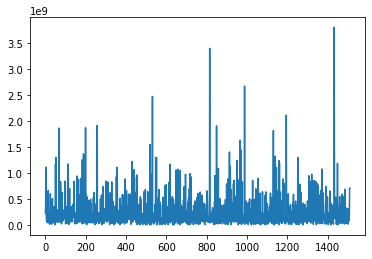

In [171]:
plt.plot(y_test)

In [119]:
print(y_pred_scale[:5])
print(y_pred_scale_LR[:5, 0])
print(y_pred_scale_Elastic[:5])

[-0.02651767 -0.03907123  0.03114991 -0.27361346 -0.1131293 ]
[-0.06412931  0.00051656 -0.1101147  -0.13817856  0.03263004]
[4.09963574e-10 4.09963574e-10 4.09963574e-10 4.09963574e-10
 4.09963574e-10]


In [134]:
print('MLP', int(scaler_y.inverse_transform([-0.02651767])))
print('LR', int(scaler_y.inverse_transform([-0.06412931])))
#print('SVR', int(scaler_y.inverse_transform([-0.02651767])))
print('Elastic', int(scaler_y.inverse_transform([4.09963574e-10])))    #
print('ground truth', y_test[0, 0])

MLP 247409275
LR 234101186
Elastic 256791996
ground truth 225177232


In [ ]:
plt.plot

# TODO

###### 회귀 데이터 증분?
###### 학습/검증 다르게 분할. 시계열
###### LBGM
###### MLP in kears, pytorch